# Notebook: Video Object Tracking Pipeline

## Section 1: Introduction

In this notebook, we'll explore how to manage a real-world computer vision problem
efficiently. We'll focus on building clean, modular, and reusable code that can later
be framed in a pipeline.

### The example: Tracking objects in a short video
Object detection is mostly used in traffic and security data, but for a small
demonstration, we'll use a short (7s) Youtube video of flamingos.

What we'd like to do is:
- detect objects in the video
- track them across frames (i.e., identify an object as one and the same throughout the
  video)
- save the tracking data to a csv file for later processing


## Section 2: Tool Overview

For this problem, we'll leverage off-the-shelf tools and libraries that simplify the workflow:

1. **Ultralytics YOLO11** for object detection (https://docs.ultralytics.com/
): Detects vehicles, pedestrians, and other objects in video frames.

2. **ByteTrack** for object tracking (https://github.com/ifzhang/ByteTrack
): Maintains consistent object IDs across frames with high accuracy, even in crowded or occluded scenes.

3. **OpenCV** for video processing and visualization (https://opencv.org/
): Reads video files, manipulates frames, and saves annotated output.

4. **Pandas / JSON** for structured output: Stores object tracking data (frame number, object ID, coordinates, class, confidence).

5. **Dagster** (not in the notebook) for pipeline orchestration (https://dagster.io/
): Manages the workflow, logs task execution, and handles dependencies and failures.


## Section 3: Workflow Overview

The pipeline will be organized as a sequence of Dagster solids (tasks):

- Load Video Frames: read and preprocess frames from video
- Run Object Detection: detect objects using YOLOv8
- Track Objects: apply ByteTrack to maintain consistent IDs across frames
- Save Tracking Data: export object tracking information to CSV or JSON.

This structure will demonstrate how to modularize CV tasks, maintain reproducibility, and monitor progress.

## Video Frame Loading

To load a video frame by frame, we'll use the `opencv-python` package (imported unintuitively as `cv2`). Let's first take a look at the video as-is, though. Afterward, we check how to access each single frame.

Here's how we do it!

In [1]:
# for running in Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


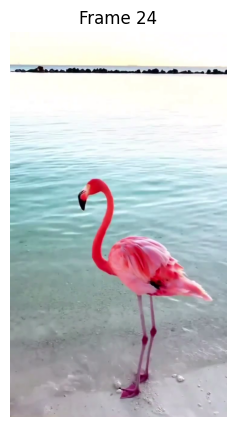

In [11]:
# Section 2.1: Video Frame Loading with OpenCV
import cv2
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

video_path = "/content/drive/MyDrive/AICamp-Share/Example02/data/flamingo.mp4"
cap = cv2.VideoCapture(video_path)
fig, ax = plt.subplots(figsize=(8, 5))

for i in range(25):
    ret, frame = cap.read()
    if not ret:
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    ax.clear()  # clear previous frame
    ax.imshow(frame_rgb)
    ax.axis('off')
    ax.set_title(f"Frame {i}")

    clear_output(wait=True)
    display(fig)
    time.sleep(0.05)

cap.release()
plt.close(fig)  # close figure at the end

## Object Detection using YOLO11

Now that we know how to access single frames of the video, we can use an object detection model to identify objects on our single images! We'll use [YOLO11](https://docs.ultralytics.com/models/yolo11/) - a well documented computer vision model trained on the 80 classes of the `COCO` (Common Objects in Context) Dataset. We'll try our hand with the last frame we extracted above.

For more information on the `COCO` Dataset, check out [ultralytic's documentation](https://docs.ultralytics.com/de/datasets/detect/coco/#dataset-yaml).

Let's take a look!


0: 640x384 1 bird, 138.0ms
Speed: 3.6ms preprocess, 138.0ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 384)


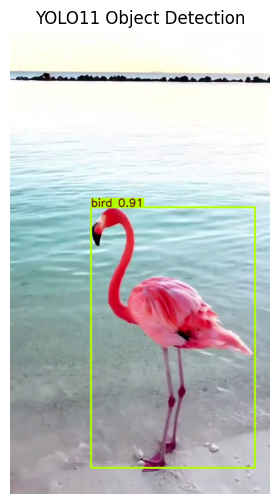

In [13]:
# Section 2.2: Object Detection with YOLOv8
!pip install ultralytics
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Assume 'frame_rgb' is the last frame extracted from Section 2.1

# Load a pre-trained YOLOv8 model (small for demo)
model = YOLO("yolo11n.pt")  # you can use yolov8s.pt or yolov8m.pt if you want more accuracy

# Run detection on the last frame
results = model(frame_rgb)


# Display detection results inline using matplotlib
fig, ax = plt.subplots(figsize=(10, 6))
annotated_frame = results[0].plot()  # returns image with boxes drawn
ax.imshow(annotated_frame)
ax.axis('off')
ax.set_title("YOLO11 Object Detection")
plt.show()

Nice! The YOLO-Model identified our flamingo correctly as a bird, with an accuracy of ~90%! The output even tells us about the preprocessing and inference times, as well as about the dimensions of our image (one image, three RGB channels for color, and 640 x 384 pixels).

## Object tracking

Now we know how to do object detection on single frames. Just by looking at the video, *we* know that the flamingo across frames is one and the same animal. However, it's not so simple for computer vision algorithms.

As a next step, we want the computer to acknowledge the flamingo as one single subject - for that, we use `ByteTracker`'s object tracking capabilities.

To see what's going on with our variables, we'll add `debugpy` to our uv environment; then we can debug cells here.

Let's check it out!

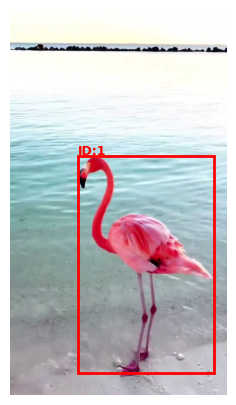

In [15]:
!pip install deep_sort_realtime
from deep_sort_realtime.deepsort_tracker import DeepSort
import cv2
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import numpy as np
import time

# initialize the tracker
tracker = DeepSort(max_age=30)

# open the video
video_path = "/content/drive/MyDrive/AICamp-Share/Example02/data/flamingo.mp4"
cap = cv2.VideoCapture(video_path)

# set up visualization
fig, ax = plt.subplots(figsize=(8, 5))

for i in range(25):
    ret, frame = cap.read()
    if not ret:
        break

    # change colors and get original frame dimensions
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # fetch model results
    results = model(frame_rgb)  # your YOLOv8 model
    boxes = results[0].boxes.xyxy.cpu().numpy()
    scores = results[0].boxes.conf.cpu().numpy()

    # Convert normalized xywh -> absolute xyxy
    detections = []
    for box, score in zip(boxes, scores):
        x1, y1, x2, y2 = box
        width = x2 - x1
        height = y2 - y1
        detections.append([[x1, y1, width, height], float(score)])

    tracks = tracker.update_tracks(detections, frame=frame_rgb)

    # plot everything
    ax.clear()
    ax.imshow(frame_rgb)
    ax.axis('off')

    for track in tracks:
        if not track.is_confirmed():
            continue
        x1, y1, width, height = track.original_ltwh # center point x/y, width, height
        track_id = track.track_id
        ax.add_patch(plt.Rectangle((x1, y1), width, height,
                                   fill=False, edgecolor='r', linewidth=2))
        ax.text(x1, y1-5, f'ID:{track_id}', color='r', fontsize=9, weight='bold')

    clear_output(wait=True)
    display(fig)
    time.sleep(0.05)

cap.release()
plt.close(fig)


## Storing tracking information

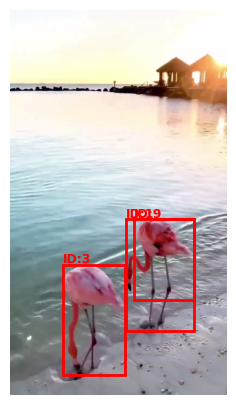

,frame,track_id,x_center,y_center
0,2,1,469.266022,872.561218
1,3,1,477.541931,852.914062
2,4,1,484.942688,844.817627
3,5,1,487.558014,834.759338
4,6,1,492.657898,830.318909


In [16]:
from deep_sort_realtime.deepsort_tracker import DeepSort
import cv2
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import numpy as np
import time
import pandas as pd

# initialize the tracker
tracker = DeepSort(max_age=30)

# open the video
video_path = "/content/drive/MyDrive/AICamp-Share/Example02/data/flamingo.mp4"
cap = cv2.VideoCapture(video_path)

# set up visualization
fig, ax = plt.subplots(figsize=(8, 5))

# set up a dataframe
columns = ["frame", "track_id", "x_center", "y_center"]
df_tracks = pd.DataFrame(columns=columns)
frame_idx = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # change colors and get original frame dimensions
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # fetch model results
    results = model(frame_rgb)  # your YOLOv8 model
    boxes = results[0].boxes.xyxy.cpu().numpy()
    scores = results[0].boxes.conf.cpu().numpy()

    # Convert normalized xywh -> absolute xyxy
    detections = []
    for box, score in zip(boxes, scores):
        x1, y1, x2, y2 = box
        width = x2 - x1
        height = y2 - y1
        detections.append([[x1, y1, width, height], float(score)])

    tracks = tracker.update_tracks(detections, frame=frame_rgb)

    # plot everything
    ax.clear()
    ax.imshow(frame_rgb)
    ax.axis('off')

    for track in tracks:
        if not track.is_confirmed():
            continue
        if track.original_ltwh is None:
            continue  # skip tracks without bounding box info

        x1, y1, width, height = track.original_ltwh # center point x/y, width, height
        track_id = track.track_id
        ax.add_patch(plt.Rectangle((x1, y1), width, height,
                                fill=False, edgecolor='r', linewidth=2))
        ax.text(x1, y1-5, f'ID:{track_id}', color='r', fontsize=9, weight='bold')

        # -----> here we log the track info to dataframe
        x_center = x1 + width / 2
        y_center = y1 + height / 2
        df_tracks = pd.concat([df_tracks, pd.DataFrame([{
            "frame": frame_idx,
            "track_id": track_id,
            "x_center": x_center,
            "y_center": y_center
        }])], ignore_index=True)

    clear_output(wait=True)
    display(fig)
    time.sleep(0.05)
    frame_idx += 1

cap.release()
plt.close(fig)

df_tracks = df_tracks.astype({"frame": int, "track_id": int}) # ensure that frame and track_id are integers
df_tracks.reset_index(drop=True, inplace=True) # make sure indices are in order after appending information!
df_tracks.head() # show the first few (5 by default) rows of the dataframe



In [17]:
# save everything
import os
save_path = "/content/drive/MyDrive/AICamp-Share/Example02/data/results"
os.makedirs(save_path, exist_ok=True)
tabulardata_path = os.path.join(save_path, "object_tracks.csv")
df_tracks.to_csv(tabulardata_path, index=True)